# **Driver distracation**

# Importation des bibliothèques

In [22]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image

from sklearn.utils import shuffle
import cv2

import os
from IPython.display import clear_output
import keras
import numpy
from keras.preprocessing.image import ImageDataGenerator
!pip install visualkeras
import visualkeras
from tensorflow.keras.applications import Xception

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
input_size = (299,299,3)

In [5]:
# Monter votre Drive afin de pouvoir y'acceder 
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Importation des données 

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c state-farm-distracted-driver-detection

100% 4.00G/4.00G [03:16<00:00, 20.8MB/s]
100% 4.00G/4.00G [03:16<00:00, 21.8MB/s]


In [8]:
from zipfile import ZipFile
file_name = "/content/state-farm-distracted-driver-detection.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [9]:
activity_map = {
    'c0': 'Safe driving', 
    'c1': 'Texting - right', 
    'c2': 'Talking on the phone - right', 
    'c3': 'Texting - left', 
    'c4': 'Talking on the phone - left', 
    'c5': 'Operating the radio', 
    'c6': 'Drinking', 
    'c7': 'Reaching behind', 
    'c8': 'Hair and makeup', 
    'c9': 'Talking to passenger'
}

# Analyse des données

Nombre d'images : 22424

Description des différents labels :

c0: normal driving \
c1: texting - right \
c2: talking on the phone - right \ 
c3: texting - left \
c4: talking on the phone - left \
c5: operating the radio \
c6: drinking \
c7: reaching behind \
c8: hair and makeup \
c9: talking to passenger \[texte du lien](https://)



Création des objets

In [10]:
drivers_imgs_list = pd.read_csv("/content/driver_imgs_list.csv")
classes = drivers_imgs_list.classname.unique()
nb_classes = len(classes)

In [ ]:

drivers_imgs_list

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


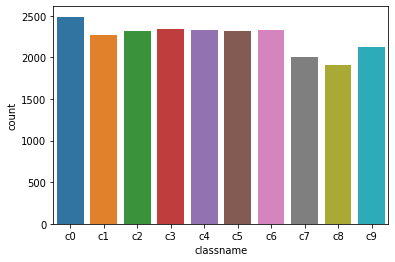

In [ ]:
sns.countplot(x="classname", data=drivers_imgs_list)


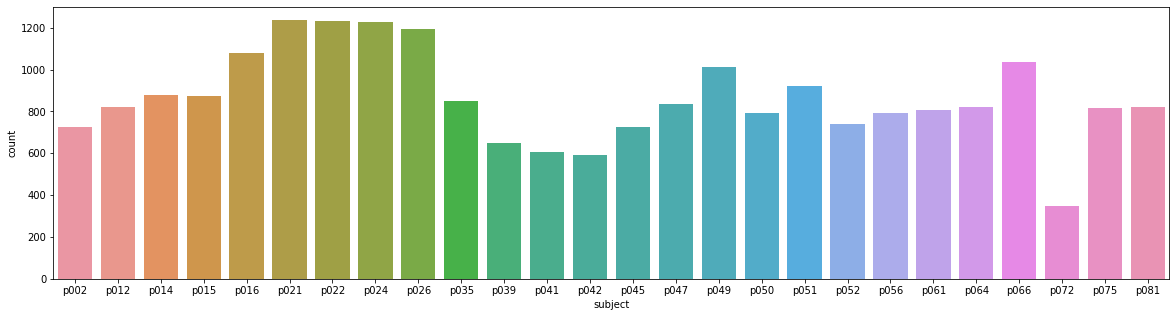

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(x="subject", data=drivers_imgs_list)

# Exemple des différentes classes :

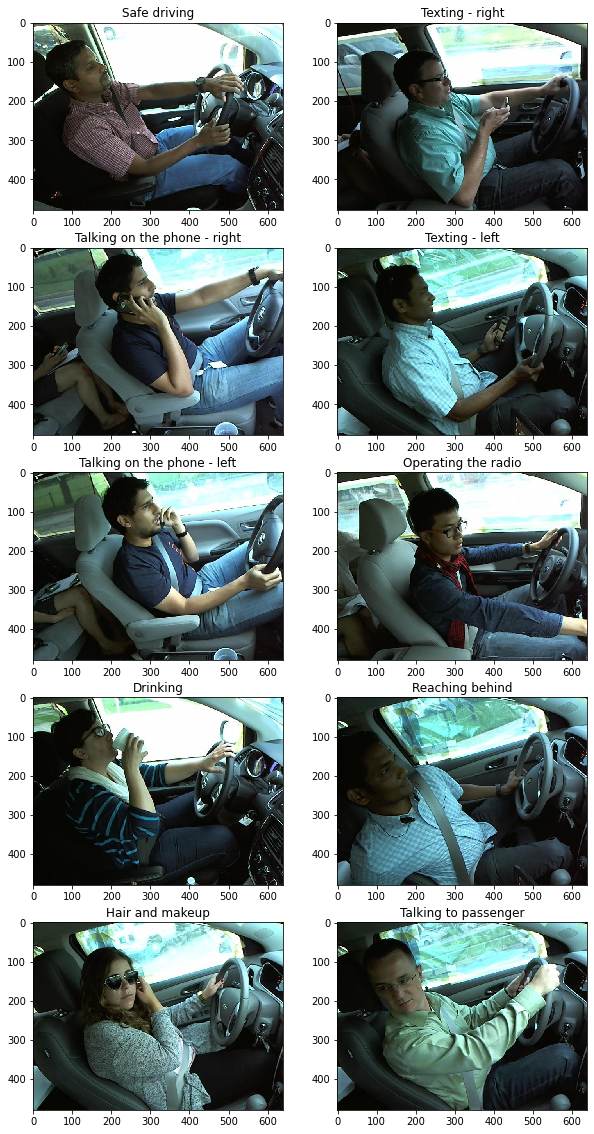

In [ ]:
plt.figure(figsize=(10,20))
for n_im,cl in enumerate(classes) : 
  # Récuperation d'un chemin d'une image au hasard parmi la classe cl

  img_name = drivers_imgs_list[drivers_imgs_list.classname == cl ]['img'].sample().to_numpy()[0]
  chemin ="imgs/train/" +str(cl)+ "/"+ img_name
  image = plt.imread(chemin)
  plt.subplot(5,2,n_im+1)
  plt.title(activity_map[cl] )
  plt.imshow(image,cmap='gray',interpolation='none')


# Création des tables de données

In [47]:
train_datagen = ImageDataGenerator(validation_split=0.2)

train_data = '/content/imgs/train'
test_data = '/content/imgs/test'
train_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=(299,299),
        batch_size=32,
        class_mode='categorical',
        subset='training')

val_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=(299,299),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


# Création du modèle avec InceptionResnetV3

In [50]:
conv_base = Xception(include_top=False,weights="imagenet",input_tensor=None,input_shape=(299,299,3),pooling='avg')
nb_couches_rentrainement = 4
nb_couches = len(conv_base.layers)
for _,layer in enumerate(conv_base.layers) : 
  if _ < nb_couches-nb_couches_rentrainement: 
    layer.trainable = False
  else : 
    layer.trainable = True

visualkeras.layered_view(conv_base,legend=True, draw_volume=True)
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_22 (Dense)            (None, 256)               524544    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 10)                1290      
                                                                 
Total params: 21,420,210
Trainable params: 3,722,378
N

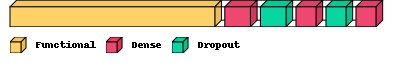

In [51]:
model = keras.models.Sequential()
    
model.add(conv_base)
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.3))    

model.add(keras.layers.Dense(nb_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

visualkeras.layered_view(model,legend=True, draw_volume=True)

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator),
                    epochs=10,
                   validation_data = val_generator, 
                   validation_steps=len(val_generator))

<ipython-input-52-591238176270>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator),


Epoch 1/10
561/561 [==============================] - 195s 341ms/step - loss: 1.3955 - accuracy: 0.4886 - val_loss: 0.7571 - val_accuracy: 0.7266
Epoch 2/10
561/561 [==============================] - 190s 339ms/step - loss: 0.4267 - accuracy: 0.8562 - val_loss: 0.3880 - val_accuracy: 0.8777
Epoch 3/10
561/561 [==============================] - 190s 339ms/step - loss: 0.2209 - accuracy: 0.9303 - val_loss: 0.5171 - val_accuracy: 0.8507
Epoch 4/10
561/561 [==============================] - 190s 339ms/step - loss: 0.1519 - accuracy: 0.9527 - val_loss: 0.3470 - val_accuracy: 0.8976
Epoch 5/10
561/561 [==============================] - 190s 338ms/step - loss: 0.1128 - accuracy: 0.9656 - val_loss: 0.1465 - val_accuracy: 0.9551
Epoch 6/10
561/561 [==============================] - 190s 339ms/step - loss: 0.0988 - accuracy: 0.9682 - val_loss: 0.1363 - val_accuracy: 0.9596
Epoch 7/10
561/561 [==============================] - 190s 338ms/step - loss: 0.0728 - accuracy: 0.9774 - val_loss: 0.2815 -

# Création du model 1

In [ ]:
img_inputs = keras.Input(shape=(224,224,3))
conv_1 = keras.layers.Conv2D(32, (5, 5), activation='relu')(img_inputs)
maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
conv_2 = keras.layers.Conv2D(64, (3, 3), activation='relu')(maxpool_1)
maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
conv_3 = keras.layers.Conv2D(64, (5, 5), activation='relu')(maxpool_2)
flatten = keras.layers.Flatten()(conv_3)
dense_1 = keras.layers.Dense(64, activation='relu')(flatten)
output = keras.layers.Dense(nb_classes, activation='softmax')(dense_1)
model = keras.Model(inputs=img_inputs, outputs=output)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 50, 50, 64)        1024

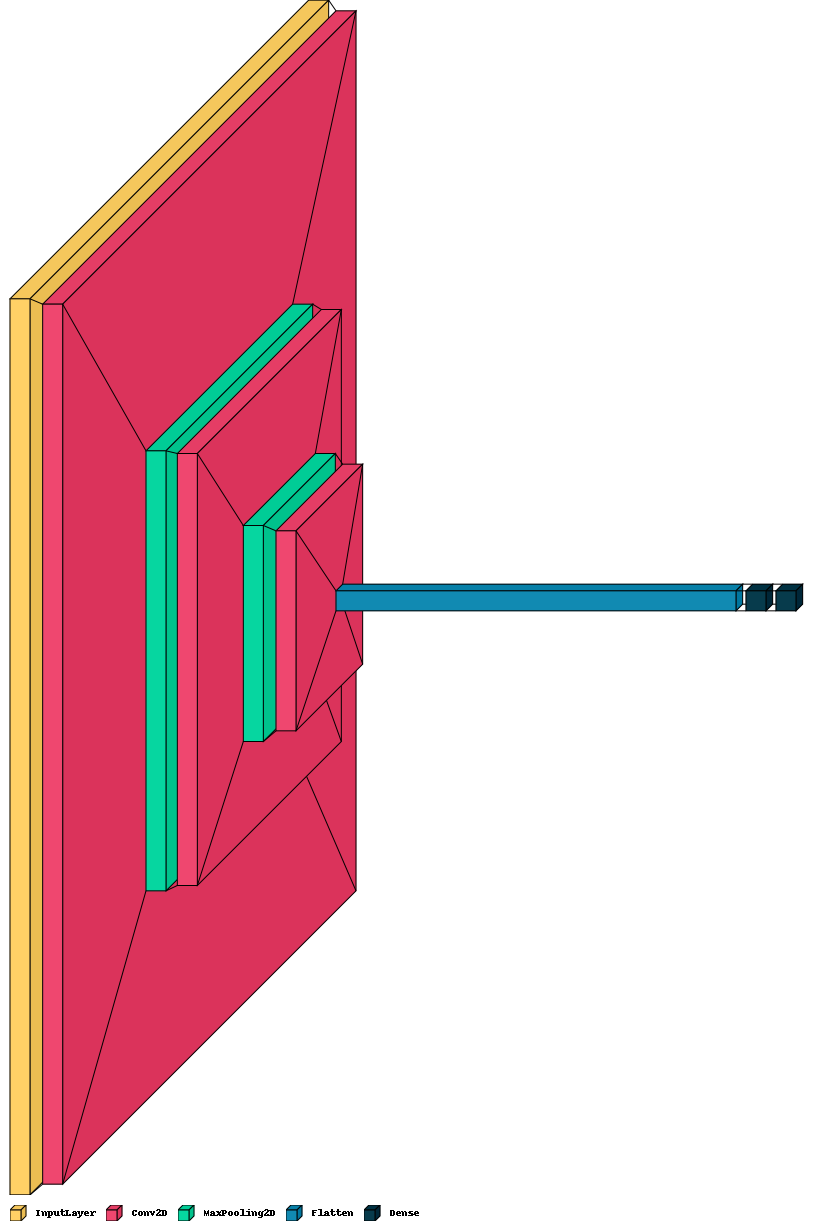

In [ ]:
model.summary()
visualkeras.layered_view(model,legend=True, draw_volume=True)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator),
                    epochs=10,
                   validation_data = val_generator,
                   validation_steps=len(val_generator))

Epoch 1/10


<ipython-input-32-aa3781269ba2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator),


561/561 [==============================] - 117s 208ms/step - loss: 2.5405 - accuracy: 0.8202 - val_loss: 0.1546 - val_accuracy: 0.9569
Epoch 2/10
561/561 [==============================] - 129s 229ms/step - loss: 0.0776 - accuracy: 0.9773 - val_loss: 0.1302 - val_accuracy: 0.9663
Epoch 3/10
224/561 [==========>...................] - ETA: 1:01 - loss: 0.0391 - accuracy: 0.9912

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 67ms/step


'Talking to passenger'

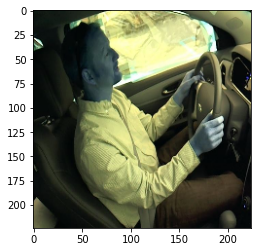

In [ ]:

img = cv2.resize(cv2.imread("/content/imgs/test/img_10007.jpg"),(224,224))
plt.imshow(img)
activity_map["c"+str(np.argmax(model.predict(np.array([img]))))]